In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt

SEED=42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)
np.random.seed(SEED)

C:\ProgramData\Anaconda3\envs\SportTensor\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\ProgramData\Anaconda3\envs\SportTensor\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


In [2]:
epo=200
bat_size=128
preco=0

In [3]:
Home_Final = pd.read_csv("Train_Test/Home_update.csv")
Home_Final = Home_Final.fillna(Home_Final.mean())

C:\Users\DELL\AppData\Local\Temp\ipykernel_14876\3987721481.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Home_Final = Home_Final.fillna(Home_Final.mean())


In [4]:
Away_Final = pd.read_csv("Train_Test/Away_update.csv")
Away_Final = Away_Final.fillna(Away_Final.mean())

C:\Users\DELL\AppData\Local\Temp\ipykernel_14876\1159211572.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Away_Final = Away_Final.fillna(Away_Final.mean())


In [5]:
# --- Step 1: Load Data ---

# --- Step 2: Feature and target setup ---
features_1 = [ 'Home_Poss','Home_Shots','Home_Target','Home_cornes','pyth', 'inflation', 'Fina_Keeper', 'Fina_Defense','Fina_Midfield', 'Fina_Forward']
features_2 = [ 'Away_Poss','Away_Shots','Away_Target','Away_cornes','pyth', 'inflation', 'Fina_Keeper', 'Fina_Defense', 'Fina_Midfield', 'Fina_Forward']

X_home = Home_Final[features_1]
y_home = Home_Final['Home_Score_home']

X_away = Away_Final[features_2]
y_away = Away_Final['Away_Score_away']

# --- Step 3: Split into train (70%), test (20%), val (10%) ---
# First split 10% validation
X_home_temp, X_home_val, y_home_temp, y_home_val = train_test_split(X_home, y_home, test_size=0.1, random_state=42)
X_away_temp, X_away_val, y_away_temp, y_away_val = train_test_split(X_away, y_away, test_size=0.1, random_state=42)

# Then split remaining 90% into 70/20 (i.e. train/test split = 7/2 of remaining 90%)
X_home_train, X_home_test, y_home_train, y_home_test = train_test_split(X_home_temp, y_home_temp, test_size=2/9, random_state=42)
X_away_train, X_away_test, y_away_train, y_away_test = train_test_split(X_away_temp, y_away_temp, test_size=2/9, random_state=42)

# --- Step 4: Standardization ---
scaler_home = StandardScaler()
scaler_away = StandardScaler()

X_home_train_scaled = scaler_home.fit_transform(X_home_train)
X_home_test_scaled = scaler_home.transform(X_home_test)
X_home_val_scaled = scaler_home.transform(X_home_val)

X_away_train_scaled = scaler_away.fit_transform(X_away_train)
X_away_test_scaled = scaler_away.transform(X_away_test)
X_away_val_scaled = scaler_away.transform(X_away_val)



# --- Step 5: Shared layers ---


def shared_mlp(input_tensor):
    x = layers.Dense(10, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED))(input_tensor)
    x = layers.Dense(22, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED))(x)
    return x



# --- Step 6: Inputs ---
home_input = Input(shape=(10,), name='home_input')
away_input = Input(shape=(10,), name='away_input')

# --- Step 7: Shared processing ---
shared_home = shared_mlp(home_input)
shared_away = shared_mlp(away_input)

# --- Step 8: Output layers ---
home_output = layers.Dense(1, name='home_output', kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED))(shared_home)
away_output = layers.Dense(1, name='away_output', kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED))(shared_away)





# --- Step 9: Define model ---
model = Model(inputs=[home_input, away_input], outputs=[home_output, away_output])


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 home_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 away_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           110         ['home_input[0][0]']             
                                                                                                  
 dense_2 (Dense)                (None, 10)           110         ['away_input[0][0]']             
                                                                                              

In [7]:
class RSquare(tf.keras.metrics.Metric):
    def __init__(self, name='r2', **kwargs):
        super(RSquare, self).__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        self.sse.assign_add(tf.reduce_sum(tf.square(y_true - y_pred)))
        self.sst.assign_add(tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))))

    def result(self):
        return 1.0 - (self.sse / (self.sst + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)


In [8]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'home_output': 'mse',
        'away_output': 'mse'
    },
    metrics={
        'home_output': [
            'mae',
            'mse',
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            RSquare(name='r2')
        ],
        'away_output': [
            'mae',
            'mse',
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            RSquare(name='r2')
        ]
    }
)


In [9]:
# --- Step 10: Train ---
history = model.fit(
    x=[X_home_train_scaled, X_away_train_scaled],
    y=[y_home_train, y_away_train],
    validation_data=([X_home_val_scaled, X_away_val_scaled], [y_home_val, y_away_val]),
    epochs=epo,
    batch_size=bat_size,
    verbose=1
)


Epoch 1/200
19/23 [=======================>......] - ETA: 0s - loss: 4.1418 - home_output_loss: 2.4350 - away_output_loss: 1.7068 - home_output_mae: 1.1995 - home_output_mse: 2.4350 - home_output_rmse: 1.5604 - home_output_r2: -0.3739 - away_output_mae: 1.0121 - away_output_mse: 1.7068 - away_output_rmse: 1.3065 - away_output_r2: -0.3518

C:\ProgramData\Anaconda3\envs\SportTensor\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric RSquare implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


23/23 [==============================] - 2s 23ms/step - loss: 4.0225 - home_output_loss: 2.3586 - away_output_loss: 1.6639 - home_output_mae: 1.1785 - home_output_mse: 2.3586 - home_output_rmse: 1.5358 - home_output_r2: -0.3629 - away_output_mae: 0.9983 - away_output_mse: 1.6639 - away_output_rmse: 1.2899 - away_output_r2: -0.3277 - val_loss: 3.6428 - val_home_output_loss: 2.0672 - val_away_output_loss: 1.5756 - val_home_output_mae: 1.0972 - val_home_output_mse: 2.0672 - val_home_output_rmse: 1.4378 - val_home_output_r2: -0.2535 - val_away_output_mae: 1.0040 - val_away_output_mse: 1.5756 - val_away_output_rmse: 1.2552 - val_away_output_r2: -0.1983
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 3.3812 - home_output_loss: 1.9704 - away_output_loss: 1.4108 - home_output_mae: 1.0865 - home_output_mse: 1.9704 - home_output_rmse: 1.4037 - home_output_r2: -0.1347 - away_output_mae: 0.9188 - away_output_mse: 1.4108 - away_output_rmse: 1.1878 - away_output_r2: -0.1191 

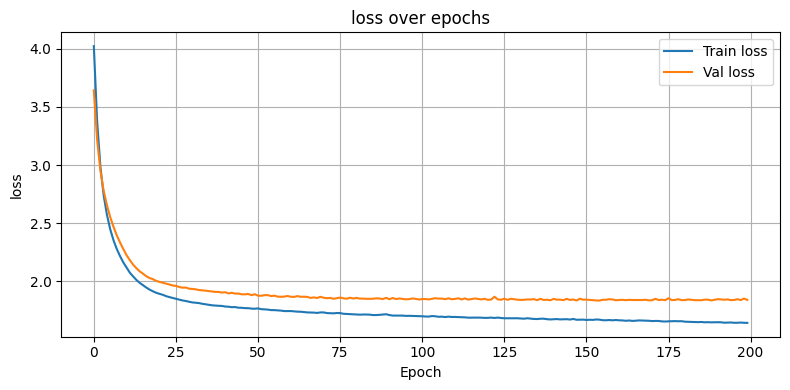

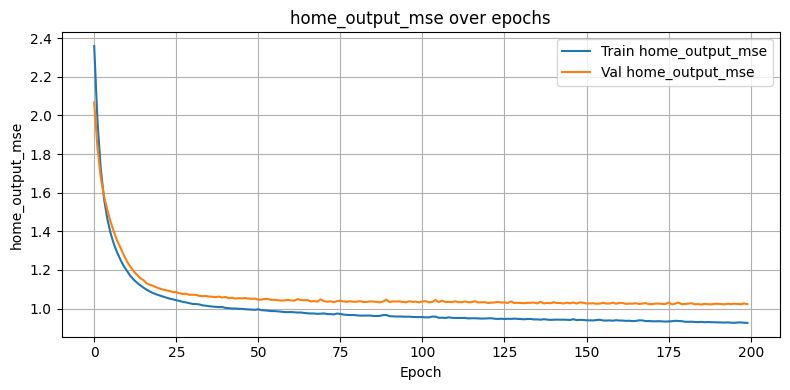

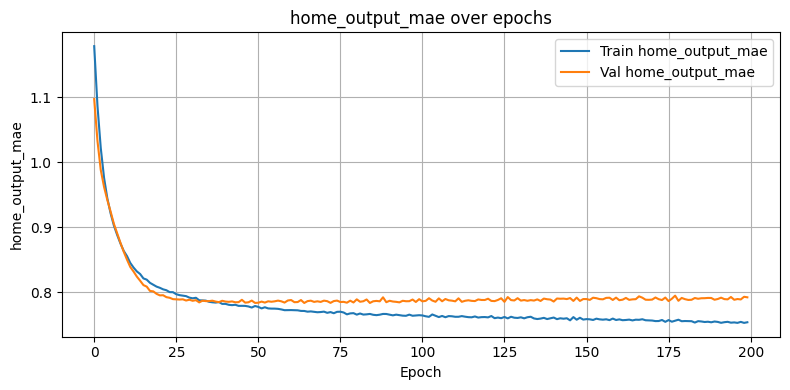

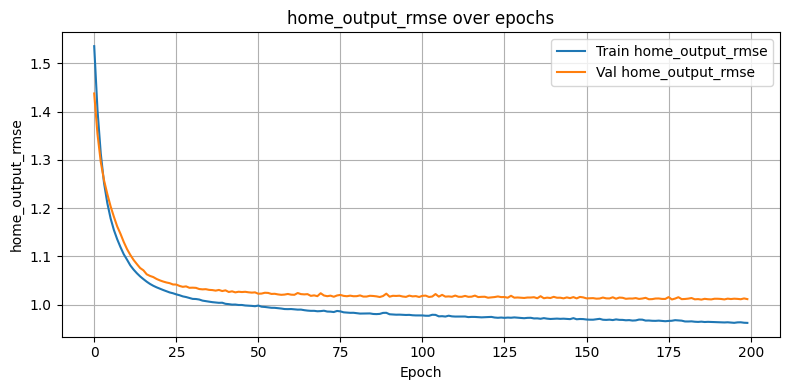

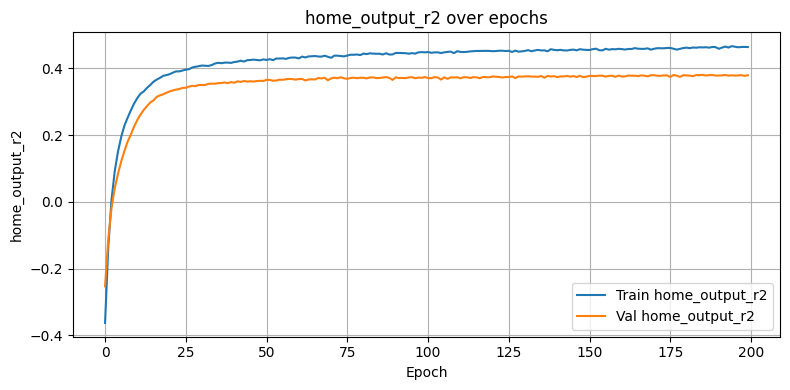

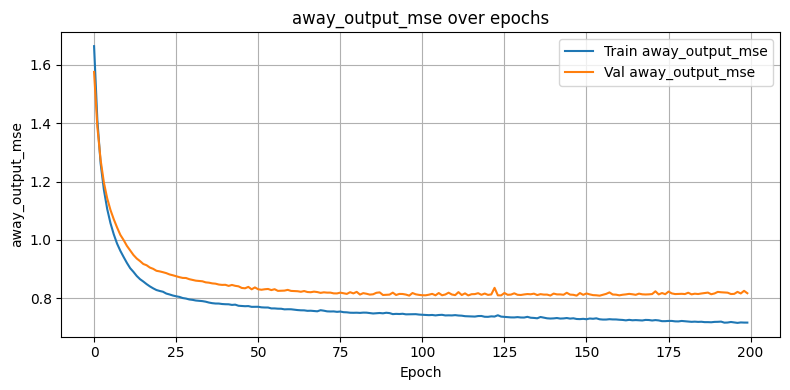

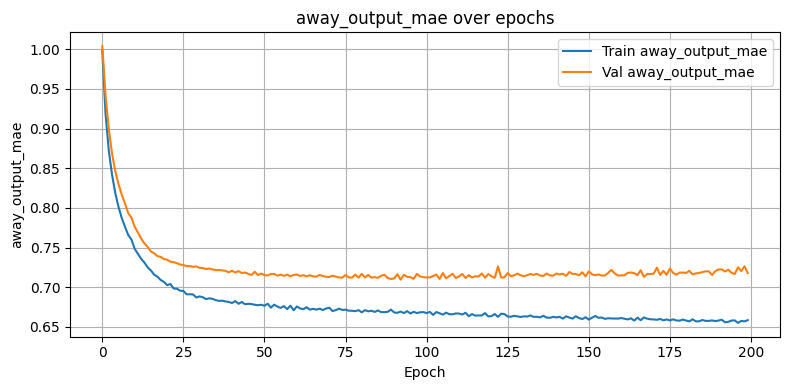

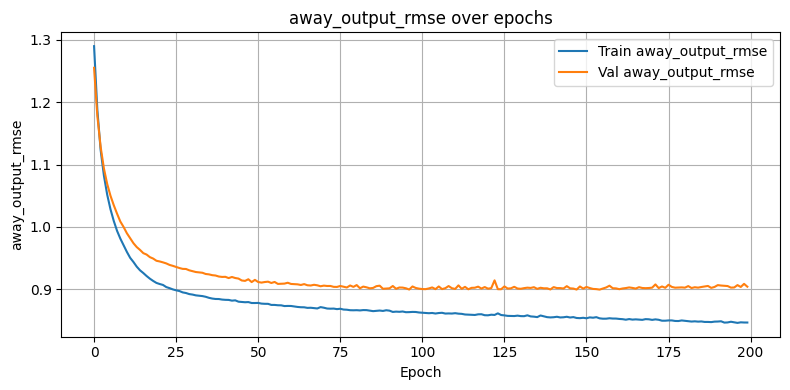

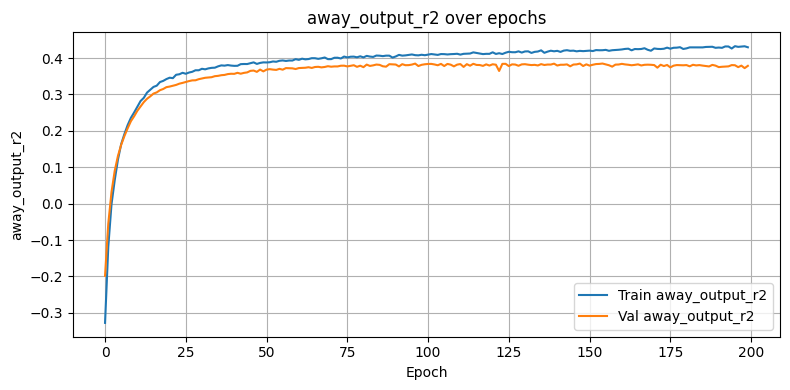

In [10]:
import matplotlib.pyplot as plt

# List of metrics to plot
metrics = ['loss', 'home_output_mse', 'home_output_mae', 'home_output_rmse', 'home_output_r2',
           'away_output_mse', 'away_output_mae', 'away_output_rmse', 'away_output_r2']

# Plot each metric
for metric in metrics:
    val_metric = f'val_{metric}'
    if metric in history.history:
        plt.figure(figsize=(8, 4))
        plt.plot(history.history[metric], label=f'Train {metric}')
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Val {metric}')
        plt.title(f'{metric} over epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [11]:
# Get the index of the last epoch
last_epoch = len(history.history['loss']) - 1

# Define a helper to safely extract metrics
def get_metric(name):
    return history.history.get(name, [None])[last_epoch]

# --- Home Output Metrics ---
home_train_mse = get_metric('home_output_mse')
home_train_mae = get_metric('home_output_mae')
home_train_rmse = get_metric('home_output_rmse')
home_train_r2 = get_metric('home_output_r2')

home_val_mse = get_metric('val_home_output_mse')
home_val_mae = get_metric('val_home_output_mae')
home_val_rmse = get_metric('val_home_output_rmse')
home_val_r2 = get_metric('val_home_output_r2')

# --- Away Output Metrics ---
away_train_mse = get_metric('away_output_mse')
away_train_mae = get_metric('away_output_mae')
away_train_rmse = get_metric('away_output_rmse')
away_train_r2 = get_metric('away_output_r2')

away_val_mse = get_metric('val_away_output_mse')
away_val_mae = get_metric('val_away_output_mae')
away_val_rmse = get_metric('val_away_output_rmse')
away_val_r2 = get_metric('val_away_output_r2')

# --- Print the results ---
print("\n Home Output - Final Epoch")
print(f"Train → MSE: {home_train_mse:.4f}, MAE: {home_train_mae:.4f}, RMSE: {home_train_rmse:.4f}, R²: {home_train_r2:.4f}")
print(f"Val   → MSE: {home_val_mse:.4f}, MAE: {home_val_mae:.4f}, RMSE: {home_val_rmse:.4f}, R²: {home_val_r2:.4f}")

print("\n Away Output - Final Epoch")
print(f"Train → MSE: {away_train_mse:.4f}, MAE: {away_train_mae:.4f}, RMSE: {away_train_rmse:.4f}, R²: {away_train_r2:.4f}")
print(f"Val   → MSE: {away_val_mse:.4f}, MAE: {away_val_mae:.4f}, RMSE: {away_val_rmse:.4f}, R²: {away_val_r2:.4f}")



 Home Output - Final Epoch
Train → MSE: 0.9260, MAE: 0.7543, RMSE: 0.9623, R²: 0.4641
Val   → MSE: 1.0232, MAE: 0.7926, RMSE: 1.0115, R²: 0.3795

 Away Output - Final Epoch
Train → MSE: 0.7165, MAE: 0.6585, RMSE: 0.8465, R²: 0.4296
Val   → MSE: 0.8172, MAE: 0.7180, RMSE: 0.9040, R²: 0.3785


In [12]:
print(home_train_r2)

0.4641134738922119


In [13]:
# --- Step 1: Make predictions on test sets ---
y_home_pred = model.predict([X_home_test_scaled, X_away_test_scaled])[0].flatten()
y_away_pred = model.predict([X_home_test_scaled, X_away_test_scaled])[1].flatten()

# --- Step 2: Compare with actual values ---
comparison_df = pd.DataFrame({
    'Actual_Home_Score': y_home_test.values,
    'Predicted_Home_Score': y_home_pred,
    'Actual_Away_Score': y_away_test.values,
    'Predicted_Away_Score': y_away_pred
})

# --- Step 3: Display first few rows ---
comparison_df.head(10)


27/27 [==============================] - 0s 1ms/step


,Actual_Home_Score,Predicted_Home_Score,Actual_Away_Score,Predicted_Away_Score
0,3.0,1.476699,1.0,1.172580
1,3.0,1.326820,2.0,1.281459
2,3.0,1.111267,0.0,1.045702
3,0.0,1.047117,2.0,2.038847
4,2.0,1.484786,2.0,1.167047
5,2.0,1.861379,1.0,1.455861
6,1.0,0.769764,1.0,0.667828
7,2.0,1.626118,0.0,0.937356
8,2.0,1.124211,0.0,0.885832
9,2.0,1.493731,1.0,0.447274


In [14]:
predictions = model.predict([X_home_test_scaled, X_away_test_scaled])
y_home_pred = predictions[0].flatten()
y_away_pred = predictions[1].flatten()

# --- Step 2: Compare with actual values and include index ---
comparison_df = pd.DataFrame({
    'Actual_Home_Score': y_home_test.values,
    'Predicted_Home_Score': y_home_pred,
    'Actual_Away_Score': y_away_test.values,
    'Predicted_Away_Score': y_away_pred
}, index=y_home_test.index)  # set the original index for clarity

# --- Step 3: Show a few results ---
comparison_df.head(10)

27/27 [==============================] - 0s 1ms/step


,Actual_Home_Score,Predicted_Home_Score,Actual_Away_Score,Predicted_Away_Score
1961,3.0,1.476699,1.0,1.172580
1996,3.0,1.326820,2.0,1.281459
3661,3.0,1.111267,0.0,1.045702
3949,0.0,1.047117,2.0,2.038847
3534,2.0,1.484786,2.0,1.167047
1624,2.0,1.861379,1.0,1.455861
2084,1.0,0.769764,1.0,0.667828
3650,2.0,1.626118,0.0,0.937356
1409,2.0,1.124211,0.0,0.885832
2445,2.0,1.493731,1.0,0.447274


In [15]:
# Example: rename column 0 to 'Home_Team' and column 2 to 'Away_Team'
Home_Final.rename(columns={Home_Final.columns[0]: 'Home_Team'}, inplace=True)

In [16]:
# Example: rename column 0 to 'Home_Team' and column 2 to 'Away_Team'
Away_Final.rename(columns={Away_Final.columns[0]: 'Away_Team'}, inplace=True)

In [17]:
# --- Step 1: Extract the rows from Home_Final and Away_Final using the index of comparison_df
home_final_filtered = Home_Final[['Home_Team', 'Home_Score_home']].loc[comparison_df.index]
away_final_filtered = Away_Final[['Away_Team', 'Away_Score_away']].loc[comparison_df.index]

# --- Step 2: Combine the two filtered dataframes
final_combined_df = pd.concat([home_final_filtered, away_final_filtered], axis=1)

In [18]:
# --- Step 1: Merge the two dataframes on the index (default index)
merged_df = pd.merge(final_combined_df, comparison_df, left_index=True, right_index=True)

In [19]:
merged_df.drop(columns=['Actual_Home_Score', 'Actual_Away_Score'], inplace=True)
# Example: rename column 0 to 'Home_Team' and column 2 to 'Away_Team'
# merged_df.rename(columns={merged_df.columns[0]: 'Home_Team'}, inplace=True)

In [20]:


# --- Actual result column ---
merged_df['Actual_Score'] = np.where(
    merged_df['Home_Score_home'] > merged_df['Away_Score_away'], 'H',
    np.where(merged_df['Home_Score_home'] < merged_df['Away_Score_away'], 'A', 'D')
)

# --- Predicted result column ---
merged_df['Perdi_Score'] = np.where(
    round(merged_df['Predicted_Home_Score'], preco) > round(merged_df['Predicted_Away_Score'], preco), 'H',
    np.where(round(merged_df['Predicted_Home_Score'], preco) < round(merged_df['Predicted_Away_Score'], preco), 'A', 'D')
)


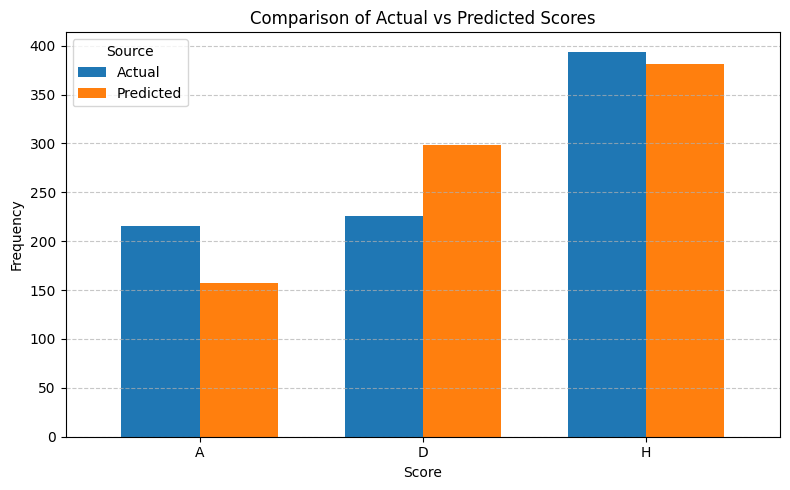

In [21]:


# Count the frequency of 'H', 'A', 'D' in both columns
actual_counts = merged_df['Actual_Score'].value_counts().sort_index()
perdi_counts = merged_df['Perdi_Score'].value_counts().sort_index()

# Create a DataFrame to hold both counts
comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': perdi_counts
}).fillna(0)

# Plotting
ax = comparison_df.plot(kind='bar', figsize=(8, 5), width=0.7)

plt.title('Comparison of Actual vs Predicted Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Source')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save as SVG
plt.savefig("comparison_scores.svg", format='svg')

# Show the plot
plt.show()


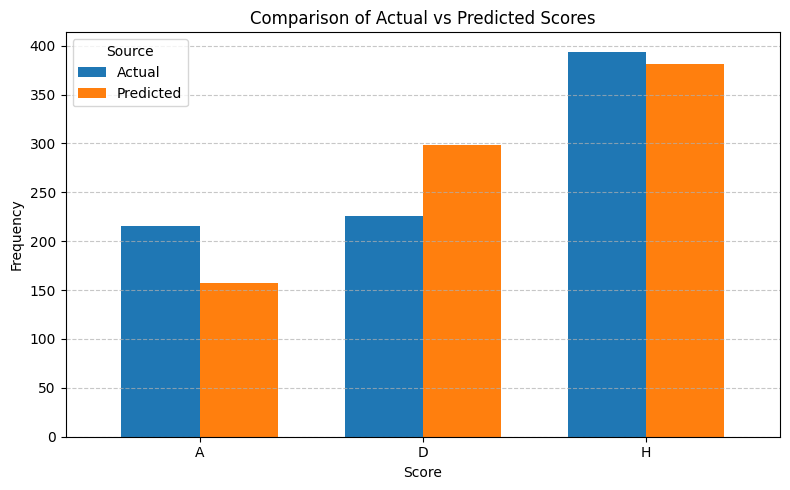

In [22]:
# Count the frequency of 'H', 'A', 'D' in both columns
actual_counts = merged_df['Actual_Score'].value_counts().sort_index()
perdi_counts = merged_df['Perdi_Score'].value_counts().sort_index()

# Create a DataFrame to hold both counts
comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': perdi_counts
}).fillna(0)  # In case a value is missing in one of the columns

# Plotting
comparison_df.plot(kind='bar', figsize=(8, 5), width=0.7)

plt.title('Comparison of Actual vs Predicted Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Source')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import confusion_matrix
# Define the class labels in the correct order
labels = ['H', 'D', 'A']

# Compute confusion matrix
cm = confusion_matrix(merged_df['Actual_Score'], merged_df['Perdi_Score'], labels=labels)

# Create a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=[f"Actual_{label}" for label in labels],
                         columns=[f"Pred_{label}" for label in labels])

print(cm_df)

          Pred_H  Pred_D  Pred_A
Actual_H     273     103      18
Actual_D      76     106      44
Actual_A      32      89      95


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define labels
labels = ['H', 'D', 'A']

# Extract ground truth and predictions
y_true = merged_df['Actual_Score']
y_pred = merged_df['Perdi_Score']

# --- Basic Metrics ---
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, labels=labels, average=None)
recall = recall_score(y_true, y_pred, labels=labels, average=None)
f1 = f1_score(y_true, y_pred, labels=labels, average=None)

# --- Print Metrics ---
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

for i, label in enumerate(labels):
    print(f"Class '{label}':")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}\n")

# --- Optional: Full classification report ---
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels))



Overall Accuracy: 0.5670

Class 'H':
  Precision: 0.7165
  Recall:    0.6929
  F1 Score:  0.7045

Class 'D':
  Precision: 0.3557
  Recall:    0.4690
  F1 Score:  0.4046

Class 'A':
  Precision: 0.6051
  Recall:    0.4398
  F1 Score:  0.5094


 Classification Report:

              precision    recall  f1-score   support

           H       0.72      0.69      0.70       394
           D       0.36      0.47      0.40       226
           A       0.61      0.44      0.51       216

    accuracy                           0.57       836
   macro avg       0.56      0.53      0.54       836
weighted avg       0.59      0.57      0.57       836



In [25]:
import os
file_path = "results4.txt"

# Check if header is needed
need_header = not os.path.exists(file_path) or os.stat(file_path).st_size == 0

# Count existing data lines to determine the next index
if os.path.exists(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
        index = len(lines) if not need_header else 1
else:
    index = 1

# Column widths
col_widths = [6, 8, 11, 15, 13, 15, 13, 8, 9, 19]

# Column labels
headers = [
    "Index", "Epoch", "BatchSize", "Home_Train_R2", "Home_Val_R2",
    "Away_Train_R2", "Away_Val_R2", "Preco", "Accuracy", "Precision_Positive"
]

with open(file_path, "a") as f:
    if need_header:
        header_line = "".join(f"{label:<{w}}" for label, w in zip(headers, col_widths))
        f.write(header_line + "\n")

    data = [
        index, epo, bat_size, round(home_train_r2, 3), round(home_val_r2, 2),
        round(away_train_r2, 2), round(away_val_r2, 2), preco,
        round(accuracy, 2), round(precision[1], 2)
    ]
    data_line = "".join(f"{str(val):<{w}}" for val, w in zip(data, col_widths))
    f.write(data_line + "\n")

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Define labels
labels = ['H', 'D', 'A']

# Extract ground truth and predictions
y_true = merged_df['Actual_Score']
y_pred = merged_df['Perdi_Score']

# --- Compute Metrics ---
report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

# Create DataFrame from classification report
report_df = pd.DataFrame(report_dict).transpose()

# Add accuracy as a row
report_df.loc['accuracy'] = ['-', '-', '-', accuracy]

# Round values for cleaner table
report_df = report_df.round(4)

# --- Plot as Table ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # Hide axes

# Plot table
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# --- Save as SVG ---
plt.title("Classification Report", fontsize=14, pad=20)
plt.savefig("classification_report.svg", format='svg')
plt.close()

print("SVG saved as 'classification_report.svg'")


SVG saved as 'classification_report.svg'


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Define labels
labels = ['H', 'D', 'A']

# Extract ground truth and predictions
y_true = merged_df['Actual_Score']
y_pred = merged_df['Perdi_Score']

# Compute metrics
report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

# Create DataFrame and round to 2 decimals
report_df = pd.DataFrame(report_dict).transpose()
report_df.loc['accuracy'] = ['-', '-', '-', accuracy]  # Append accuracy
report_df = report_df.round(2)  # Round to 2 decimals

# Plot table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Classification Report", fontsize=14, pad=20)
plt.savefig("classification_report01.svg", format='svg')
plt.close()

print("SVG saved as 'classification_report.svg'")


SVG saved as 'classification_report.svg'
